<a href="https://colab.research.google.com/github/st43r/GarbageCounter/blob/main/GarbageCounterYOLO_NAS_L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
def convert_to_yolo_format(input_file, output_dir, class_mapping):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.strip().split(', ')
        frame_number, object_id, label, x, y, w, h = map(float, parts[0:7])

        x_center = x
        y_center = y
        width = w
        height = h

        yolo_line = f"{int(label)} {x_center} {y_center} {width} {height}"


        output_file = os.path.join(output_dir, f"{int(frame_number):04d}.txt")

        with open(output_file, 'a') as yolo_file:
            yolo_file.write(yolo_line + '\n')


In [ ]:
import os

PATH = "/content/drive/MyDrive/annotations/"

input_files =["video0.txt","video1.txt","video2.txt"]
output_dirs = ["video0/","video1/","video2/"]


class_mapping = { 0, 1, 2, 3}

i = 0


for file in input_files:

    if not os.path.exists(PATH+output_dirs[i]):
      os.makedirs(PATH+output_dirs[i])

    convert_to_yolo_format(file, PATH+output_dirs[i], class_mapping)

    i+=1

In [ ]:
import os

folders = ["video0", "video1", "video2"]

for folder in folders:
  directory_path = '/content/drive/MyDrive/annotations/'+folder+'/'

  files = [file for file in os.listdir(directory_path) if file.endswith('.txt')]

  for file in files:
    new_name = folder+file
    new_path = directory_path+new_name

    os.rename(directory_path+file, new_path)



In [ ]:
%pip install -q super-gradients
%pip install -q roboflow
%pip install -q supervision

In [3]:
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
MODEL_ARCH = 'yolo_nas_l'

In [4]:
DEVICE

'cuda'

In [ ]:
from super_gradients.training import models

model = models.get(MODEL_ARCH, pretrained_weights="coco").to(DEVICE)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="RwY5mwZ8dTcek6gGhodh")
project = rf.workspace("garbagecounter").project("garbagecounter")
dataset = project.version(4).download("yolov5")

In [6]:
LOCATION = dataset.location
print("location:", LOCATION)
CLASSES = sorted(project.classes.keys())
print("classes:", CLASSES)

location: /content/GarbageCounter-4
classes: ['glass', 'metal', 'plastic', 'wood']


In [7]:
MODEL_ARCH = 'yolo_nas_l'
BATCH_SIZE = 8
MAX_EPOCHS = 64
CHECKPOINT_DIR = "/content/drive/MyDrive/chkpts"
EXPERIMENT_NAME = project.name.lower().replace(" ", "_")

In [17]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

In [8]:
dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

In [19]:
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

[2023-10-29 05:10:49] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 2139/2139 [00:03<00:00, 639.28it/s]
[2023-10-29 05:10:53] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 205/205 [00:00<00:00, 575.01it/s]
[2023-10-29 05:10:53] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


In [ ]:
from super_gradients.training import models

In [ ]:
model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

In [11]:
best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path="/content/drive/MyDrive/chkpts/garbagecounter/RUN_20231027_183433_903009/average_model.pth"
).to(DEVICE)

[2023-10-29 05:04:57] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/chkpts/garbagecounter/RUN_20231027_183433_903009/average_model.pth EMA checkpoint.


In [20]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(
    model=best_model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

In [13]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml",
    force_masks=False
)

In [ ]:
import supervision as sv

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

In [15]:
import random
random.seed(10)

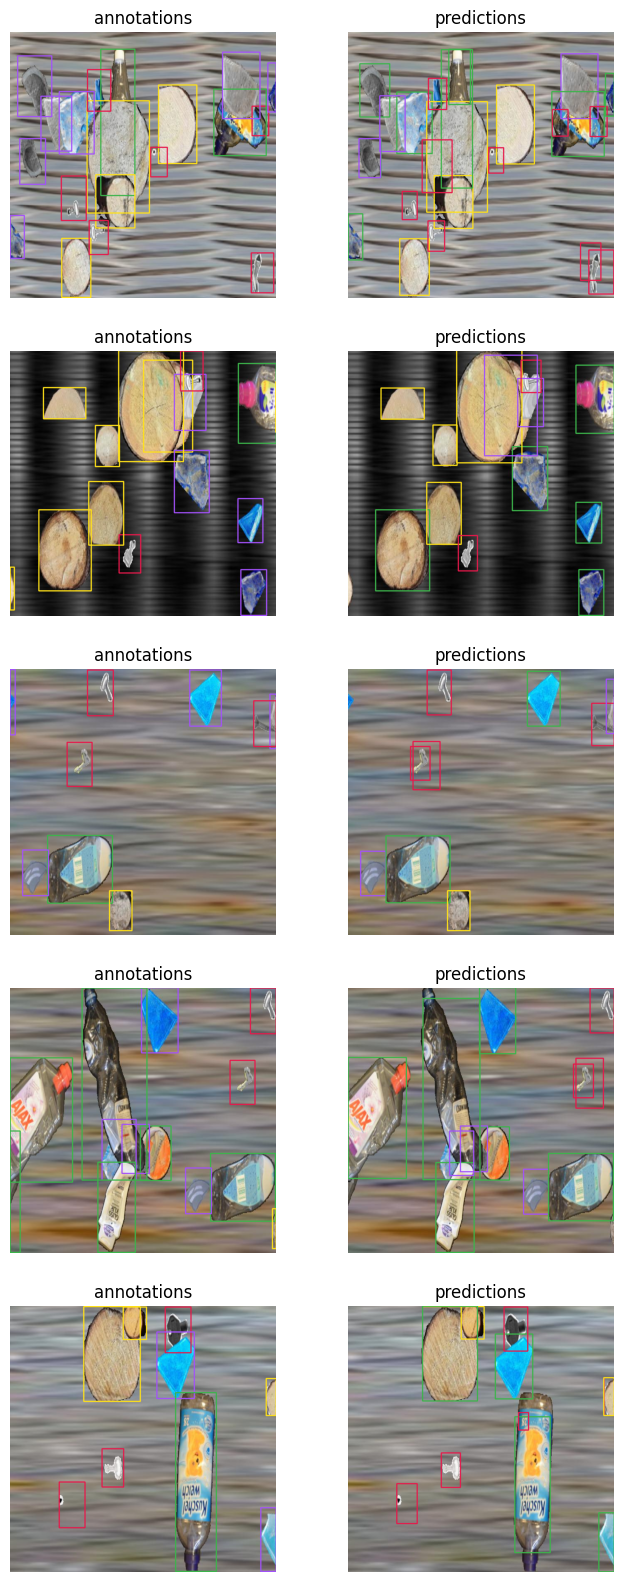

In [16]:
import supervision as sv

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

In [21]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)

Testing: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


{'Precision@0.50': 0.10978779196739197,
 'Recall@0.50': 0.9825073480606079,
 'mAP@0.50': 0.9495899081230164,
 'F1@0.50': 0.19387906789779663}

In [26]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install onemetric

FileNotFoundError: ignored

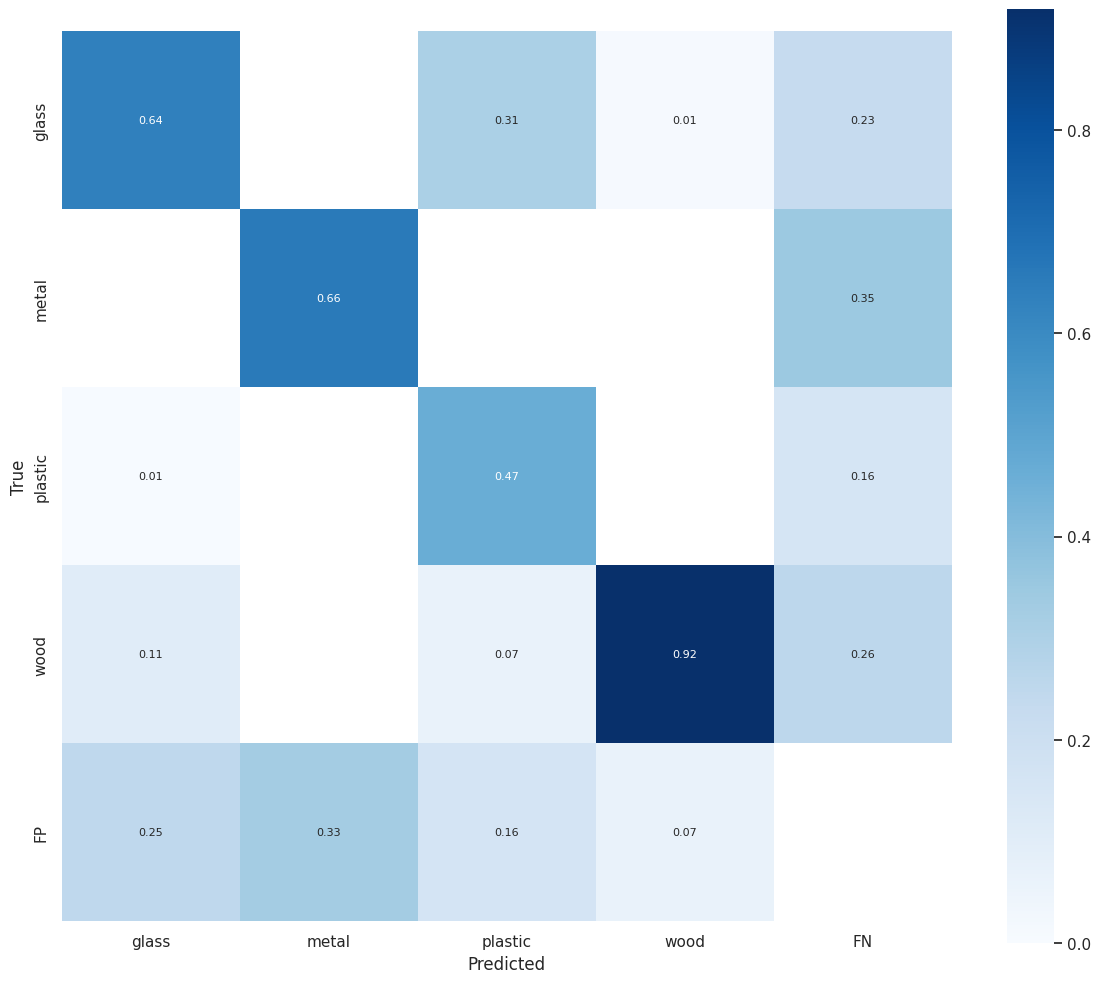

In [31]:
import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join("/content/drive/MyDrive/chkpt/","confusion_matrix.png"), class_names=ds.classes)